# FOOOF: Tuning & Troubleshooting

<div class="alert alert-success">
This notebook covers tips & tricks for setting FOOOF parameters, and tuning fits, and troubleshooting any issues.
</div>

<div class="alert alert-info">
If you want to first explore examples of using the FOOOF code base, go back [here](02-FOOOF.ipynb).
</div>

In [1]:
%matplotlib inline

import numpy as np

# FOOOF imports
from fooof import FOOOF, FOOOFGroup

# Import some utilities, and tools for creating synthetic power-spectra
from fooof.synth import gen_power_spectrum, gen_group_power_spectra
from fooof.core.utils import group_three

In [2]:
# Set random state, for to freeze the generate synthetic data
np.random.seed(321)

In [3]:
## Create a noisy synthetic power spectrum
# Background parameters, as [offset, slope]
bg_params = [20, 2]
# Gaussian peak parameters 
gauss_params = [10, 1.0, 2.5, 20, 0.8, 2, 32, 0.6, 1]

# Create a synthetic power spectrum
freqs, spectrum = gen_power_spectrum([1, 50], bg_params, gauss_params, nlv=0.1)

## FOOOF Settings

With default settings, FOOOF is minimally constrained. It defaults as such since there are not universal settings that work across all different dataset modalities. Appropriate settings also vary with power spectrum quality (noise, or effectively, the smoothness of the power spectrum), and frequency ranges. 

For any given dataset, FOOOF will likely need some tuning of parameters for optimal performance. 

To do so, we suggest using a combination of the following considerations:
- A priori constraints, given your data, such as the number of peaks you expect to extract
- Qualitative analysis, guided by examing the the plotted model fit results, as compared to input data
- Quantitative analysis, considering the model fit and error (however, see note at the bottom regarding interpreting model fit error)

Tuning FOOOF is an imperfect art, and should be done carefully, as assumptions built into the settings chosen will impact the model results. 

We also recommend that FOOOF settings should not be changed between power spectra (across channels, trials, or subjects), if they are to be meaningfully compared. We therefore recommend first testing out FOOOF across some representative spectra, in order to select FOOOF settings, which you then keep constant for the full analysis. 

### Tuning FOOOF

With the defaults, FOOOF is relatively unconstrained, and therefore, most commonly FOOOF will overfit, being overzealous at fitting small noisy bumps as peaks. If you move to a new dataset, you may also find you need to relax some settings, for better fits. You also need to make sure you pick an appropriate background fitting procedure, and that your data meets the assumptions of the approach you choose. 

The remainder of this notebook goes through some examples of setting FOOOF parameters to be most appropriate for various datasetes.

## Interpreting Model Fit Quality Measures

FOOOF calculates and returns a couple metrics to assist with assessing the quality of the model fits. It calculates both the model fit error, as the root mean-squared error (RMSE) between the full mode fit ('fooofed\_spectrum\_)' and the original power spectrum, as well as the R-squared correspondance between the original spectrum and the FOOOFed result. 

These scores can be used to assess how the model is performing. However there interpretation can be a little nuanced. FOOOF is NOT optimized to minimize fit error / maximize r-squared at all costs. To do so typically results in fitting a large number of gaussian processes, in a way that overfits noise.

FOOOF is therefore tuned to try and measure the background and peaks in a parsimonious manner, such as to not overfit noise, and following a fuzzy definition of only fitting peaks where there are actually significant peaks over and above the background, and the noise. One way we assessed this is by assessing the model to mimic how an expert human rater would label putative oscillatory 'peaks', as so overall, the model is not directly designed to optimize model fit error / r-squared.

Given this, while high error / low r-squared may indicate a poor model fit, very low error / high r-squared may also indicate a power spectrum that is overfit, in which case the peak parameters from the model may be overfit, and thus not offer a good description of the underlying data. 

We therefore recommend that, for a given dataset, initial explorations should involve checking both cases in which model fit error is particularly large, as well as when it is particularly low. These explorations can be used to set parameters that are suitable for running across a group. There are not universal parameters that optimize this, and so FOOOF leaves it up to the user to set parameters appropriately to not under- or over-fit for a given modality / dataset / application.

### Reducing Overfitting

If FOOOF appears to be overfitting (for example, fitting too many gaussians to small bumps), try:

- Setting a lower-bound bandwidth-limit, to exclude 
- Setting a maximum number of peaks that the algorithm may fit: max_n_peaks
    - If set, the algorithm will fit (up to) the max_n_peaks highest power peaks.
- Setting a minimum absolute amplitude for peaks: min_peak_amplitude


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):    

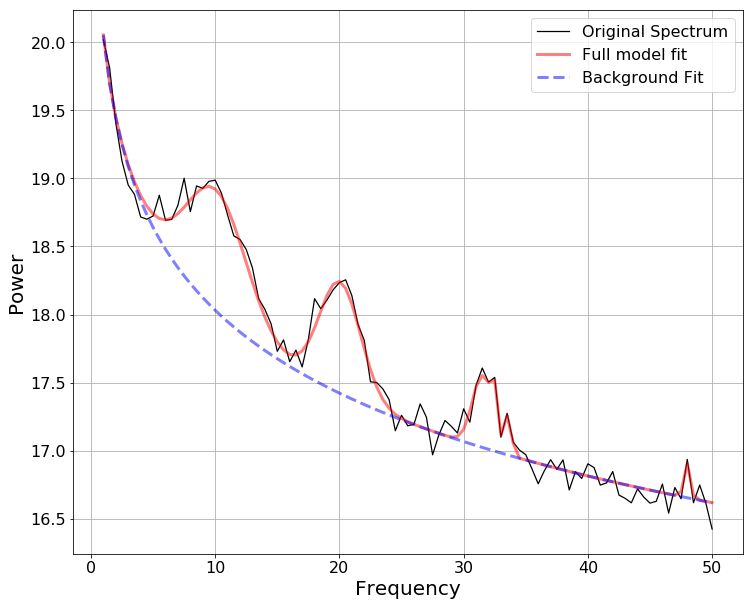

In [4]:
# Fit an (unconstrained) FOOOF model, liable to overfit
fm = FOOOF()
fm.report(freqs, spectrum)

Notice that in the above fit, we are very likely to think that FOOOF has been overzealous in fitting peaks, and is therefore overfitting. 

This is also suggested by the model r-squared, which is suspiciously high, given the amount of noise we expect. 

To reduce this kind of overfitting, we can update the FOOOF parameters.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         20.0466, 2.0155                                          
                                                                                                  
                                       3 peaks were found:                                        
          

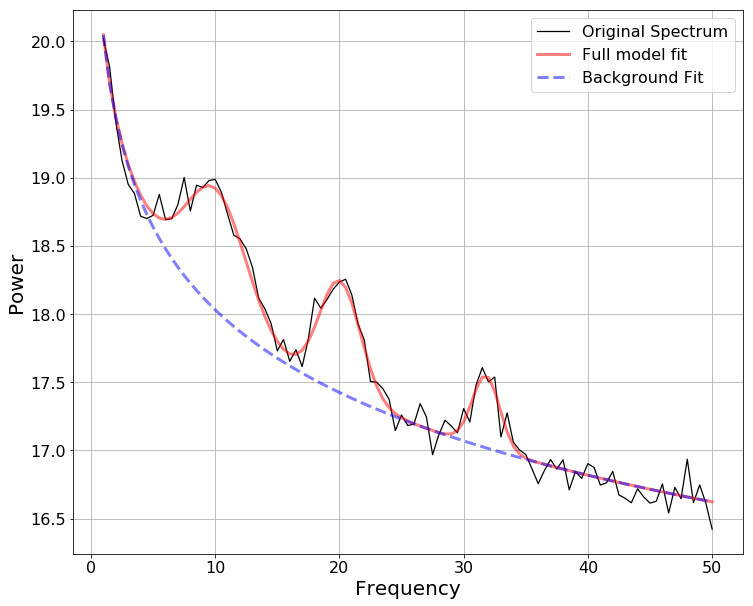

In [5]:
# Update settings to fit a more constrained FOOOF model, to reduce overfitting
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_amplitude=0.4)
fm.report(freqs, spectrum)

The synthetic definition is defined in terms of gaussian parameters. 

We can compare how FOOOF, with our updated settings, compares to the ground truth of the synthetic spectrum. 

In [6]:
# Compare ground truth synthetic parameters to model fit results
for sy, fi in zip(np.array(group_three(gauss_params)), fm._gaussian_params):
    print(sy, '\t', fi)

[ 10.    1.    2.5] 	 [ 10.09171095   0.89247344   2.42854977]
[ 20.    0.8   2. ] 	 [ 20.0505769    0.82184222   1.66001154]
[ 32.    0.6   1. ] 	 [ 31.80170268   0.53056698   1.10319569]


### Power spectra with no peaks

A known case in which FOOOF can overfit is in power spectra in which no peaks are present. In this case, the standard deviation can be very low, and so the relative amplitude check ('min_peak_threshold') is very liberal at keeping gaussian fits. 

If you expect, or know, you have power-spectra without peaks in your data, we therefore recommend updating 'min_peak_amplitude', as otherwise FOOOF is unlikely to appropriately fit power spectra as having no peaks. 

### Reducing Underfitting

If you are finding that FOOOF is underfitting:
- First check and perhaps loosen any restrictions from 'max_n_peaks' and 'min_peak_amplitude'
- Try updating 'amp_std_thresh' to a lower value
- Bad fits may come from issues with background fitting. If so, see below. 

In [7]:
## Create a cleaner synthetic power spectrum, with smaller peaks
# Background parameters, as [offset, slope]
bg_params = [20, 2]
# Gaussian peak parameters 
gauss_params = [10, 1.0, 1.0, 20, 0.3, 1.5, 32, 0.25, 1]

# Create a synthetic power spectrum
freqs, spectrum = gen_power_spectrum([1, 50], bg_params, gauss_params, nlv=0.025)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         20.0090, 2.0051                                          
                                                                                                  
                                       3 peaks were found:                                        
          

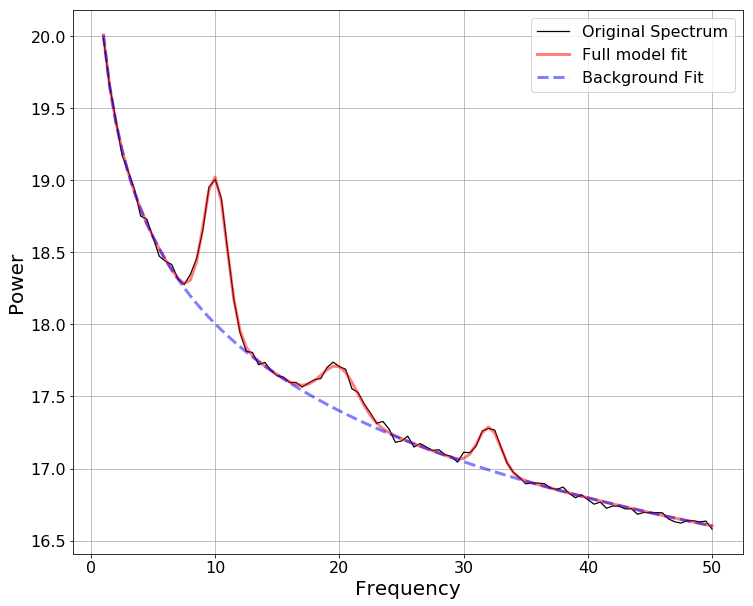

In [8]:
# Update settings to make sure they are sensitive to smaller peaks in smoother power spectra
fm = FOOOF(peak_width_limits=[1, 8], max_n_peaks=6, min_peak_amplitude=0.2)
fm.report(freqs, spectrum)

In [9]:
# Check reconstructed parameters from synthetic definition
for sy, fi in zip(np.array(group_three(gauss_params)), fm._gaussian_params):
    print(sy, '\t', fi)

[ 10.   1.   1.] 	 [ 10.00458215   1.01865454   0.94689294]
[ 20.    0.3   1.5] 	 [ 20.00455993   0.30601155   1.45023314]
[ 32.     0.25   1.  ] 	 [ 32.08422607   0.29850532   0.91720714]


### Background Fitting

FOOOF currently offers two approaches to background fitting:
- Fitting a 1/f, as a linear fit in log-log
- Fitting a 1/f, including a 'knee' parameters, reflecting a fit with a bend, in log-log

Fitting without a knee assumes a singular 1/f background, and will go wrong if this assumption is violated.

Fitting with a knee is still experimental, with a couple outstanding issues:
- Interpreting the fit results when using knee fits is not 
- Fitting FOOOF with knee fits may perform sub-optimally in ambiguous cases (where the data may or may not have a knee)

Given this, we recommend:
- Check your data, across the frequency range of interest, for what the background looks like. 
    - If it looks to exhibit a single background (there appears to be a background line in log-log), fit without a knee. 
        - This is likely across smaller frequency ranges, such as 3-30. 
        - Do not fit no-knee fits across a range that this does not hold. 
    - If there is a clear knee then use knee fits. 
        - This is likely across larger fitting ranges such as 1-150 Hz. 
- Be wary of ambiguous ranges, where there may or may not be a knee.
    - Trying to fit without a knee, when there is not a single consistent 1/f can lead to very bad fits, but it is also a known issue that trying to fit with a knee can lead to suboptimal fits when no knee is present. 
        - We therefore currently recommend picking frequency ranges in which the expected background process is relatively clear. 

### Checking fits across a group

In [10]:
# Set the parameters options for background and gaussian peaks
bgp_opts = [[20, 2], [50, 2.5], [35, 1.5]]
gauss_opts = [[], [10, 0.5, 2], [10, 0.5, 2, 20, 0.3, 4]]

# Generate a group of power spectra
freqs, power_spectra = gen_group_power_spectra(10, [3, 50], bgp_opts, gauss_opts)

In [11]:
# Initialize a FOOOFGroup
fg = FOOOFGroup(peak_width_limits=[1, 6])

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 10                             
                                                                                                  
                        The model was run on the frequency range 3 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

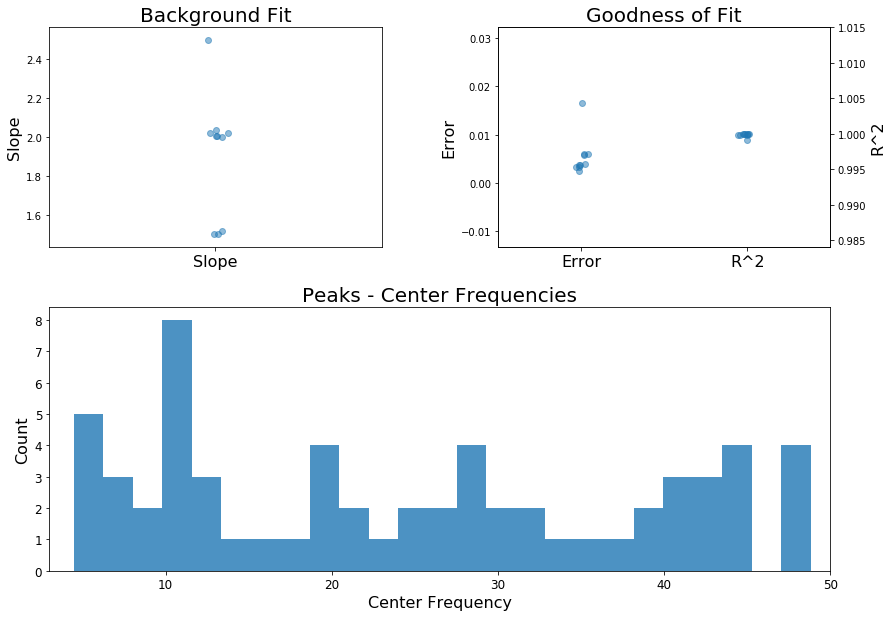

In [12]:
# Fit FOOOF and report on the group
fg.report(freqs, power_spectra)

In [13]:
# Find the index of the worst FOOOF fit from the group
worst_fit_ind = np.argmax(fg.get_all_data('error'))

# Extract this FOOOF fit from the group, into a FOOOF object
fm = fg.get_fooof(worst_fit_ind, regenerate=True)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         20.0684, 2.0359                                          
                                                                                                  
                                       2 peaks were found:                                        
          

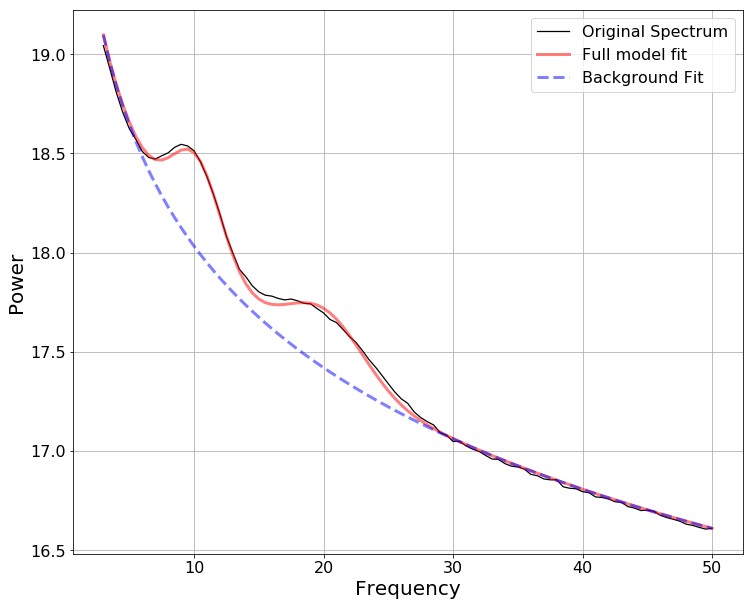

In [14]:
# Check out the model fit of the extracted FOOOF model
fm.print_results()
fm.plot()

You can also loop through all the results in a test group, extracting all fits that meet some criterion that makes them worth checking. 

This might be checking for fits above some error threshold, as below, but note that you may also want to do a similar procedure to examine fits with the lowest error, to check if FOOOF may be overfitting, or perhaps fits with a particularly large number of gaussians. 

In [15]:
# Extract all fits that are above some error threshold, for further examination. 
#  You could also do a similar analysis for particularly low errors
to_check = []
for ind, res in enumerate(fg):
    if res.error > 0.010:
        to_check.append(fg.get_fooof(ind, regenerate=True))

# A more condensed version of the procedure above can also be used, like this:
#to_check = [fg.get_fooof(ind, True) for ind, res in enumerate(fg) if res.error > 0.010]

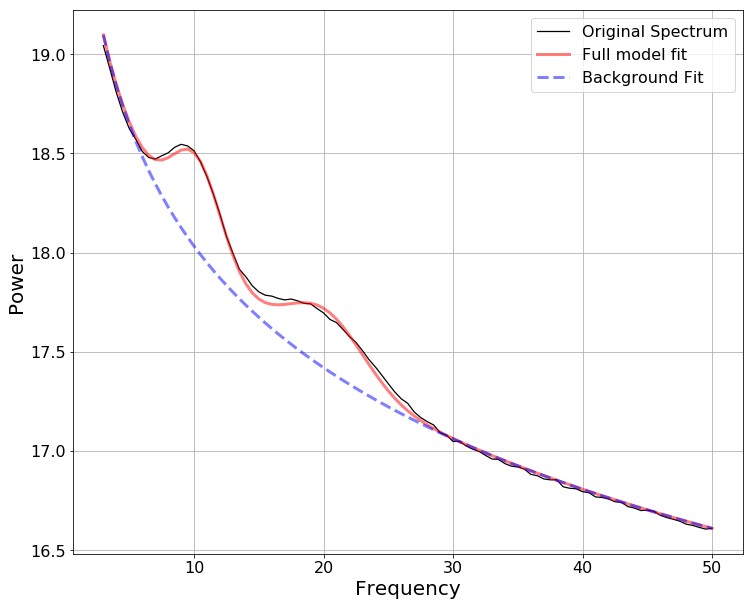

In [16]:
# Loop through the problem fits, checking the plots, and saving out reports, to check later. 
for ind, fm in enumerate(to_check):
    fm.plot()
    fm.save_report('Report_ToCheck_#' + str(ind))

### Reporting Bad Fits

If, after working through these suggestions, you are still getting bad fits, and/or are just not sure what is going on, please get in touch! We will hopefully be able to make further recommendations, and this also serves as a way for us to investigate when and why FOOOF fails, so that we can continue to make it better. 

You can report issues on Github [here](https://github.com/voytekresearch/fooof/issues), or get in touch with us by e-mail at voytekresearch@gmail.com. 

FOOOF also includes a helper method to print out instructions for reporting bad fits / bugs back to us, as demonstrated below.  


In [17]:
# Print out instructions to report bad fits
#  Note you can also call this from FOOOFGroup, and from instances (ex: fm.print_report_issue())
FOOOF.print_report_issue()

                                                                                                  
                              CONTACT / REPORTING ISSUES WITH FOOOF                               
                                                                                                  
                      Please report any bugs or unexpected errors on Github.                      
                          https://github.com/voytekresearch/fooof/issues                          
                                                                                                  
                   If FOOOF gives you any weird / bad fits, please let us know!                   
                    To do so, send us a FOOOF report, and a FOOOF data file,                      
                                                                                                  
               With a FOOOF object (fm), after fitting, run the following commands:               
          

<hr>
<div class="alert alert-info">
To continue the tutorial, exploring further analysis of FOOOF results, go [here](06-FurtherAnalysis.ipynb).
</div>